# Packages to Import

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, PolynomialFeatures
from category_encoders import TargetEncoder, BinaryEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, cross_val_score

# Data Set Loading and Checking for Null Values

### Loading the Data Set

In [2]:
file_path="C:/Users/sai27/Documents/DataScience/Projects/Luxury products rating/fashion_data.csv"
fashion_data_df = pd.read_csv(file_path)

### Working on a Copy of the original Data set

In [3]:
To_clean_df = fashion_data_df.copy()

### Checking for Null Values

##### Before Cleaning

In [4]:
Null_check_before = fashion_data_df.isnull().sum()
Null_columns_before = Null_check_before[Null_check_before > 0].sort_values(ascending=True)
Null_columns_before

product_color                 1
product_season                2
product_material              4
product_description           7
seller_username              39
product_keywords           1183
product_category           1183
has_cross_border_fees     13736
buyers_fees               13736
usually_ships_within     154791
dtype: int64

##### After Cleaning

In [6]:
Null_check_after = To_clean_df.isnull().sum()
Null_columns_after = Null_check_after[Null_check_after > 0].sort_values(ascending=True)
Null_columns_after

Series([], dtype: int64)

# Data Cleaning

In [5]:
# STEP 1
# Removing rows where seller_id does not have seller_username
NaN_usernames_ids=To_clean_df[['seller_username', 'seller_id']][To_clean_df[['seller_username', 'seller_id']].isnull().any(axis=1)].sort_values('seller_username')['seller_id'].unique().tolist()

To_clean_df = To_clean_df[~To_clean_df['seller_id'].isin(NaN_usernames_ids)]
To_clean_df.reset_index(drop=True, inplace=True)

# STEP 2
# Filling missing values in product_category
no_nan_cat = To_clean_df[['product_category', 'product_gender_target', 'product_type']].dropna()
category_mapping = no_nan_cat.set_index(['product_gender_target', 'product_type'])['product_category'].to_dict()
def map_category(row):
    return category_mapping.get((row['product_gender_target'], row['product_type']), row['product_category'])

To_clean_df['product_category'] = To_clean_df.apply(
    lambda row: map_category(row) if pd.isnull(row['product_category']) else row['product_category'], axis=1)

# STEP 3
# Filling missing values in product_color
To_clean_df['product_color'] = To_clean_df['product_color'].fillna('Multicolor')

# STEP 4
# Filling missing values in product_season
season_mapping = {'Silk scarf': 'Autumn / Winter','Sunglasses': 'All seasons'}
To_clean_df['product_season'] = To_clean_df['product_season'].fillna(To_clean_df['product_type'].map(season_mapping))

# STEP 5
# Filling missing values in product_material
materials_keywords = {'metal': ['Gold', 'silver', 'steel', 'metal'],'leather': ['strap', 'belt', 'leather']}

def infer_material(description):
    for material, keywords in materials_keywords.items():
        if any(keyword.lower() in description.lower() for keyword in keywords):
            return material
    return 'Not specified'

To_clean_df['product_material'] = To_clean_df.apply(lambda row: infer_material(row['product_description']) if pd.isna(row['product_material']) else row['product_material'], axis=1)

# STEP 6
# Filling missing values in product_keywords
def construct_keywords(row):
    return f"{row['brand_name']} {row['product_type']}"

To_clean_df['product_keywords'] = To_clean_df.apply(lambda row: construct_keywords(row) if pd.isna(row['product_keywords']) else row['product_keywords'], axis=1)

# STEP 7
# Filling missing values in product_description
def construct_description(row):
    return f"{row['brand_name']} {row['product_color']} {row['product_type']}"

To_clean_df['product_description'] = To_clean_df.apply(lambda row: construct_description(row) if pd.isna(row['product_description']) else row['product_description'], axis=1)

# STEP 8
# Filling values in has_cross_border_fees
def fill_cross_border_fees(df, default_value=False):
    most_frequent = df.groupby('seller_username')['has_cross_border_fees'].agg(lambda x: x.value_counts().index[0] if not x.isna().all() else None) 
    most_frequent_dict = most_frequent.to_dict()

    df['has_cross_border_fees'] = df.apply(lambda row: most_frequent_dict[row['seller_username']] if pd.isna(row['has_cross_border_fees']) else row['has_cross_border_fees'], axis=1)

    df['has_cross_border_fees'] = df['has_cross_border_fees'].fillna(False)

    return df

fill_cross_border_fees(To_clean_df, default_value=False)

# STEP 9
# Filling missing values in buyers_fees
def fill_buyers_fees(df, default_value=0.00):
    mean_fees = df.groupby('seller_username')['buyers_fees'].mean()
    mean_fees_dict = mean_fees.to_dict()

    df['buyers_fees'] = df.apply(lambda row: mean_fees_dict[row['seller_username']] if pd.isna(row['buyers_fees']) else row['buyers_fees'], axis=1)

    df['buyers_fees'] = df['buyers_fees'].fillna(0.00)

    return df

fill_buyers_fees(To_clean_df, default_value=0.0)

# STEP 10
# Filling missing values in usually_ships_within
def fill_usually_ships_within(df, default_value='More than 7 days'):
    most_frequent = df.groupby('seller_username')['usually_ships_within'].agg(lambda x: x.value_counts().index[0] if not x.isna().all() else None) 
    most_frequent_dict = most_frequent.to_dict()

    df['usually_ships_within'] = df.apply(lambda row: most_frequent_dict[row['seller_username']] if pd.isna(row['usually_ships_within']) else row['usually_ships_within'], axis=1)

    df['usually_ships_within'] = df['usually_ships_within'].fillna('More than 7 days')

    return df

fill_usually_ships_within(To_clean_df, default_value='More than 7 days')

C:\Users\sai27\AppData\Local\Temp\ipykernel_6696\3515533931.py:61: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['has_cross_border_fees'] = df['has_cross_border_fees'].fillna(False)


,product_id,product_type,product_name,product_description,product_keywords,product_gender_target,product_category,product_season,product_condition,product_like_count,...,seller_community_rank,seller_num_followers,seller_pass_rate,seller_badge,has_cross_border_fees,buyers_fees,warehouse_name,usually_ships_within,seller_price,seller_earning
0,43247626,Wool mini skirt,Wool mini skirt Miu Miu Grey size S Internatio...,Miu Miu – Pleated mini skirt Size: 36 (S) Wai...,Miu Miu Wool Skirts,Women,Women Clothing,Autumn / Winter,Never worn,34,...,0,13,0.0,Common,True,78.65,Tourcoing,More than 7 days,223.65,216.94
1,43247441,Jacket,Jacket Barbara Bui Navy size 42 FR in Cotton,For selling nice women's suit Barbara Bui size...,Barbara Bui Cotton Jackets,Women,Women Clothing,All seasons,Very good condition,1,...,0,8,0.0,Common,True,21.30,Tourcoing,More than 7 days,106.50,106.50
2,43246517,Wool coat,Wool coat Comme Des Garcons White size S Inter...,Magnificent boiled wool coat. I bought it in t...,Comme Des Garcons Wool Coats,Women,Women Clothing,Autumn / Winter,Very good condition,2,...,0,62,96.0,Expert,True,213.00,Tourcoing,1-2 days,1065.00,926.55
3,43246507,Mini skirt,Mini skirt MSGM Black size 38 IT in Polyester,MSGM Skirt Black Printed Raw-Edge & Embroidere...,MSGM Polyester Skirts,Women,Women Clothing,All seasons,Very good condition,0,...,126346,131,96.0,Expert,True,14.90,Brooklyn,1-2 days,149.00,126.65
4,43246417,Vegan leather trousers,Vegan leather trousers LVIR Black size 36 FR i...,LVIR black grained faux leather trousers size ...,LVIR Vegan leather Trousers,Women,Women Clothing,All seasons,Very good condition,1,...,102821,40,89.0,Common,True,19.95,Crawley,3-5 days,99.77,83.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
900470,41538360,Glitter trainers,Glitter trainers Bally Gold size 38 EU in Glit...,"Bally Vita Parcours sneakers. PPleather, suede...",Bally Glitter Trainers,Women,Women Shoes,All seasons,Good condition,1,...,391778,104,100.0,Expert,True,14.91,Tourcoing,1-2 days,74.55,60.71
900471,41532271,Leather heels,Leather heels Casadei Black size 38.5 EU in Le...,Trendy and classic Casadei high-heel pumps Mad...,Casadei Leather Heels,Women,Women Shoes,All seasons,Good condition,1,...,51408,75,89.0,Expert,True,25.56,Tourcoing,1-2 days,127.80,108.63
900472,41538140,Leather cowboy boots,Leather cowboy boots Ash Black size 36 EU in L...,Very good quality leather boots Worn once Elas...,Ash Leather Boots,Women,Women Shoes,All seasons,Very good condition,0,...,0,3,0.0,Common,True,31.95,Tourcoing,More than 7 days,159.75,138.98
900473,41537603,Leather ballet flats,Leather ballet flats Lauren Ralph Lauren Black...,Very beautiful ballet flats like new. I don't ...,Lauren Ralph Lauren Leather Ballet flats,Women,Women Shoes,All seasons,Very good condition,27,...,0,11,100.0,Trusted,True,9.59,Tourcoing,1-2 days,47.93,34.08


##### Save the Cleaned Data Frame into a New CSV file

In [ ]:
To_clean_df.to_csv('C:/Users/sai27/Documents/DataScience/Projects/Luxury products rating/cleaned_fashion_data.csv', index=False)

# Feature Engineering

##### Load the new cleaned CSV for further analysis

In [3]:
trial = pd.read_csv('C:/Users/sai27/Documents/DataScience/Projects/Luxury products rating/cleaned_fashion_data.csv')

C:\Users\sai27\AppData\Local\Temp\ipykernel_1680\3137526332.py:1: DtypeWarning: Columns (36) have mixed types. Specify dtype option on import or set low_memory=False.
  trial = pd.read_csv('C:/Users/sai27/Documents/DataScience/Projects/Luxury products rating/cleaned_fashion_data.csv')


### Creating new features

In [4]:

# Calculate the average price for each brand
trial['avg_price_per_brand'] = trial.groupby('brand_name')['price_usd'].transform('mean')

# Calculate the price range for each brand (max - min)
trial['price_range_per_brand'] = trial.groupby('brand_name')['price_usd'].transform(lambda x: x.max() - x.min())

# Calculate the average price for each product category
trial['avg_price_per_category'] = trial.groupby('product_category')['price_usd'].transform('mean')

# Calculate the price range for each product category (max - min)
trial['price_range_per_category'] = trial.groupby('product_category')['price_usd'].transform(lambda x: x.max() - x.min())

# Calculate the average price for each product type
trial['avg_price_per_type'] = trial.groupby('product_type')['price_usd'].transform('mean')

# Calculate the price range for each product type (max - min)
trial['price_range_per_type'] = trial.groupby('product_type')['price_usd'].transform(lambda x: x.max() - x.min())

# Calculate the average price for each product material
trial['avg_price_per_material'] = trial.groupby('product_material')['price_usd'].transform('mean')

# Calculate the price range for each product material (max - min)
trial['price_range_per_material'] = trial.groupby('product_material')['price_usd'].transform(lambda x: x.max() - x.min())

# Calculate the average price for each product condition
trial['avg_price_per_condition'] = trial.groupby('product_condition')['price_usd'].transform('mean')

# Calculate the price range for each product condition (max - min)
trial['price_range_per_condition'] = trial.groupby('product_condition')['price_usd'].transform(lambda x: x.max() - x.min())

# Calculate the average price for each seller country
trial['avg_price_per_seller_country'] = trial.groupby('seller_country')['price_usd'].transform('mean')

# Calculate the price range for each seller country (max - min)
trial['price_range_per_seller_country'] = trial.groupby('seller_country')['price_usd'].transform(lambda x: x.max() - x.min())

# Calculate the average price for each seller badge
trial['avg_price_per_seller_badge'] = trial.groupby('seller_badge')['price_usd'].transform('mean')

# Calculate the price range for each seller badge (max - min)
trial['price_range_per_seller_badge'] = trial.groupby('seller_badge')['price_usd'].transform(lambda x: x.max() - x.min())

# Calculate the average price for each usually ships within
trial['avg_price_per_ships_within'] = trial.groupby('usually_ships_within')['price_usd'].transform('mean')

# Calculate the price range for each usually ships within (max - min)
trial['price_range_per_ships_within'] = trial.groupby('usually_ships_within')['price_usd'].transform(lambda x: x.max() - x.min())
# Calculate the average price for each buyers fees
trial['avg_price_per_buyers_fees'] = trial.groupby('buyers_fees')['price_usd'].transform('mean')

# Calculate the price range for each buyers fees (max - min)
trial['price_range_per_buyers_fees'] = trial.groupby('buyers_fees')['price_usd'].transform(lambda x: x.max() - x.min())

# Calculate mean earning_percentage for each category in the feature
# Step 1: Convert earning_percentage to numeric, coercing errors to NaN
trial['earning_percentage'] = pd.to_numeric(trial['earning_percentage'], errors='coerce')
# Step 2: Fill the NaN with 0
trial['earning_percentage'] = trial['earning_percentage'].fillna(0)
# Step 3: Round off
trial['earning_percentage'] = trial['earning_percentage'].round()

trial['earning_percentage_by_brand_name'] = trial.groupby('brand_name')['earning_percentage'].transform('mean').round()

trial['earning_percentage_by_product_category'] = trial.groupby('product_category')['earning_percentage'].transform('mean').round()

trial['earning_percentage_by_product_gender_target'] = trial.groupby('product_gender_target')['earning_percentage'].transform('mean').round()

trial['earning_percentage_by_product_material'] = trial.groupby('product_material')['earning_percentage'].transform('mean').round()

trial['earning_percentage_by_product_type'] = trial.groupby('product_type')['earning_percentage'].transform('mean').round()

trial['earning_percentage_by_product_condition'] = trial.groupby('product_condition')['earning_percentage'].transform('mean').round()

trial['earning_percentage_by_product_season'] = trial.groupby('product_season')['earning_percentage'].transform('mean').round()

trial['earning_percentage_by_product_color'] = trial.groupby('product_color')['earning_percentage'].transform('mean').round()

trial['earning_percentage_by_seller_country'] = trial.groupby('seller_country')['earning_percentage'].transform('mean').round()

trial['earning_percentage_by_seller_badge'] = trial.groupby('seller_badge')['earning_percentage'].transform('mean').round()

trial['earning_percentage_by_usually_ships_within'] = trial.groupby('usually_ships_within')['earning_percentage'].transform('mean').round()

trial['earning_percentage_by_has_cross_border_fees'] = trial.groupby('has_cross_border_fees')['earning_percentage'].transform('mean').round()


### Removing less usefull columns

In [5]:

unwanted_columns = ['product_id', 'product_name', 'product_description', 'product_keywords', 'brand_url', 'brand_id', 'seller_id', 'reserved']
trial_feature_selection = trial.drop(unwanted_columns, axis=1)


### Defining the categorical columns to be encoded in different encoding methods accordings and perform mapping according to the need

In [9]:

# Columns for different encoding methods
ordinal_cols = ['product_season', 'product_category', 'product_gender_target', 'product_condition', 'seller_badge','warehouse_name', 'usually_ships_within']
target_cols = ['product_color', 'product_type', 'product_material', 'brand_name', 'seller_username', 'seller_country']
binary_cols = ['sold', 'available', 'in_stock', 'should_be_gone', 'has_cross_border_fees']

# Define the order for ordinal encoding where applicable
ordinal_mapping = {'product_season': ['Spring / Summer', 'All seasons', 'Autumn / Winter'],
                   'product_category': ['Women Clothing', 'Women Accessories', 'Women Shoes', 'Men Clothing', 'Men Accessories', 'Men Shoes'],
                   'product_gender_target': ['Men', 'Women'],
                   'product_condition': ['Fair condition', 'Good condition', 'Very good condition', 'Never worn', 'Never worn, with tag'],
                   'seller_badge': ['Common', 'Expert', 'Trusted'],
                   'warehouse_name': ['Tourcoing', 'Brooklyn', 'Crawley', 'Hong Kong', 'New York', 'Paris'],
                   'usually_ships_within': ['More than 7 days', '6-7 days', '3-5 days', '1-2 days']}

# Apply binary encoding directly by mapping True/False to 1/0
binary_cols_map = {'sold': [False, True], 'available': [False, True], 'in_stock': [False, True],
                   'should_be_gone': [False, True], 'has_cross_border_fees': [False, True]}


### Perform encoding

In [10]:

binary_enc = OrdinalEncoder(categories=[binary_cols_map[col] for col in binary_cols])

# Apply binary encoding
trial_feature_selection[binary_cols] = binary_enc.fit_transform(trial_feature_selection[binary_cols])

# Initialize the OrdinalEncoder with the specified mapping
ordinal_enc = OrdinalEncoder(categories=[ordinal_mapping[col] for col in ordinal_cols])

# Apply ordinal encoding
trial_feature_selection[ordinal_cols] = ordinal_enc.fit_transform(trial_feature_selection[ordinal_cols])

# Initialize the TargetEncoder
target_enc = TargetEncoder()

# Apply target encoding
trial_feature_selection[target_cols] = target_enc.fit_transform(trial_feature_selection[target_cols], trial_feature_selection['seller_price'])


# Data Visualizing, Handling Outliers and Feature Selection

### Correlation Matrix and Heatmap on initial cleaned and encoded data

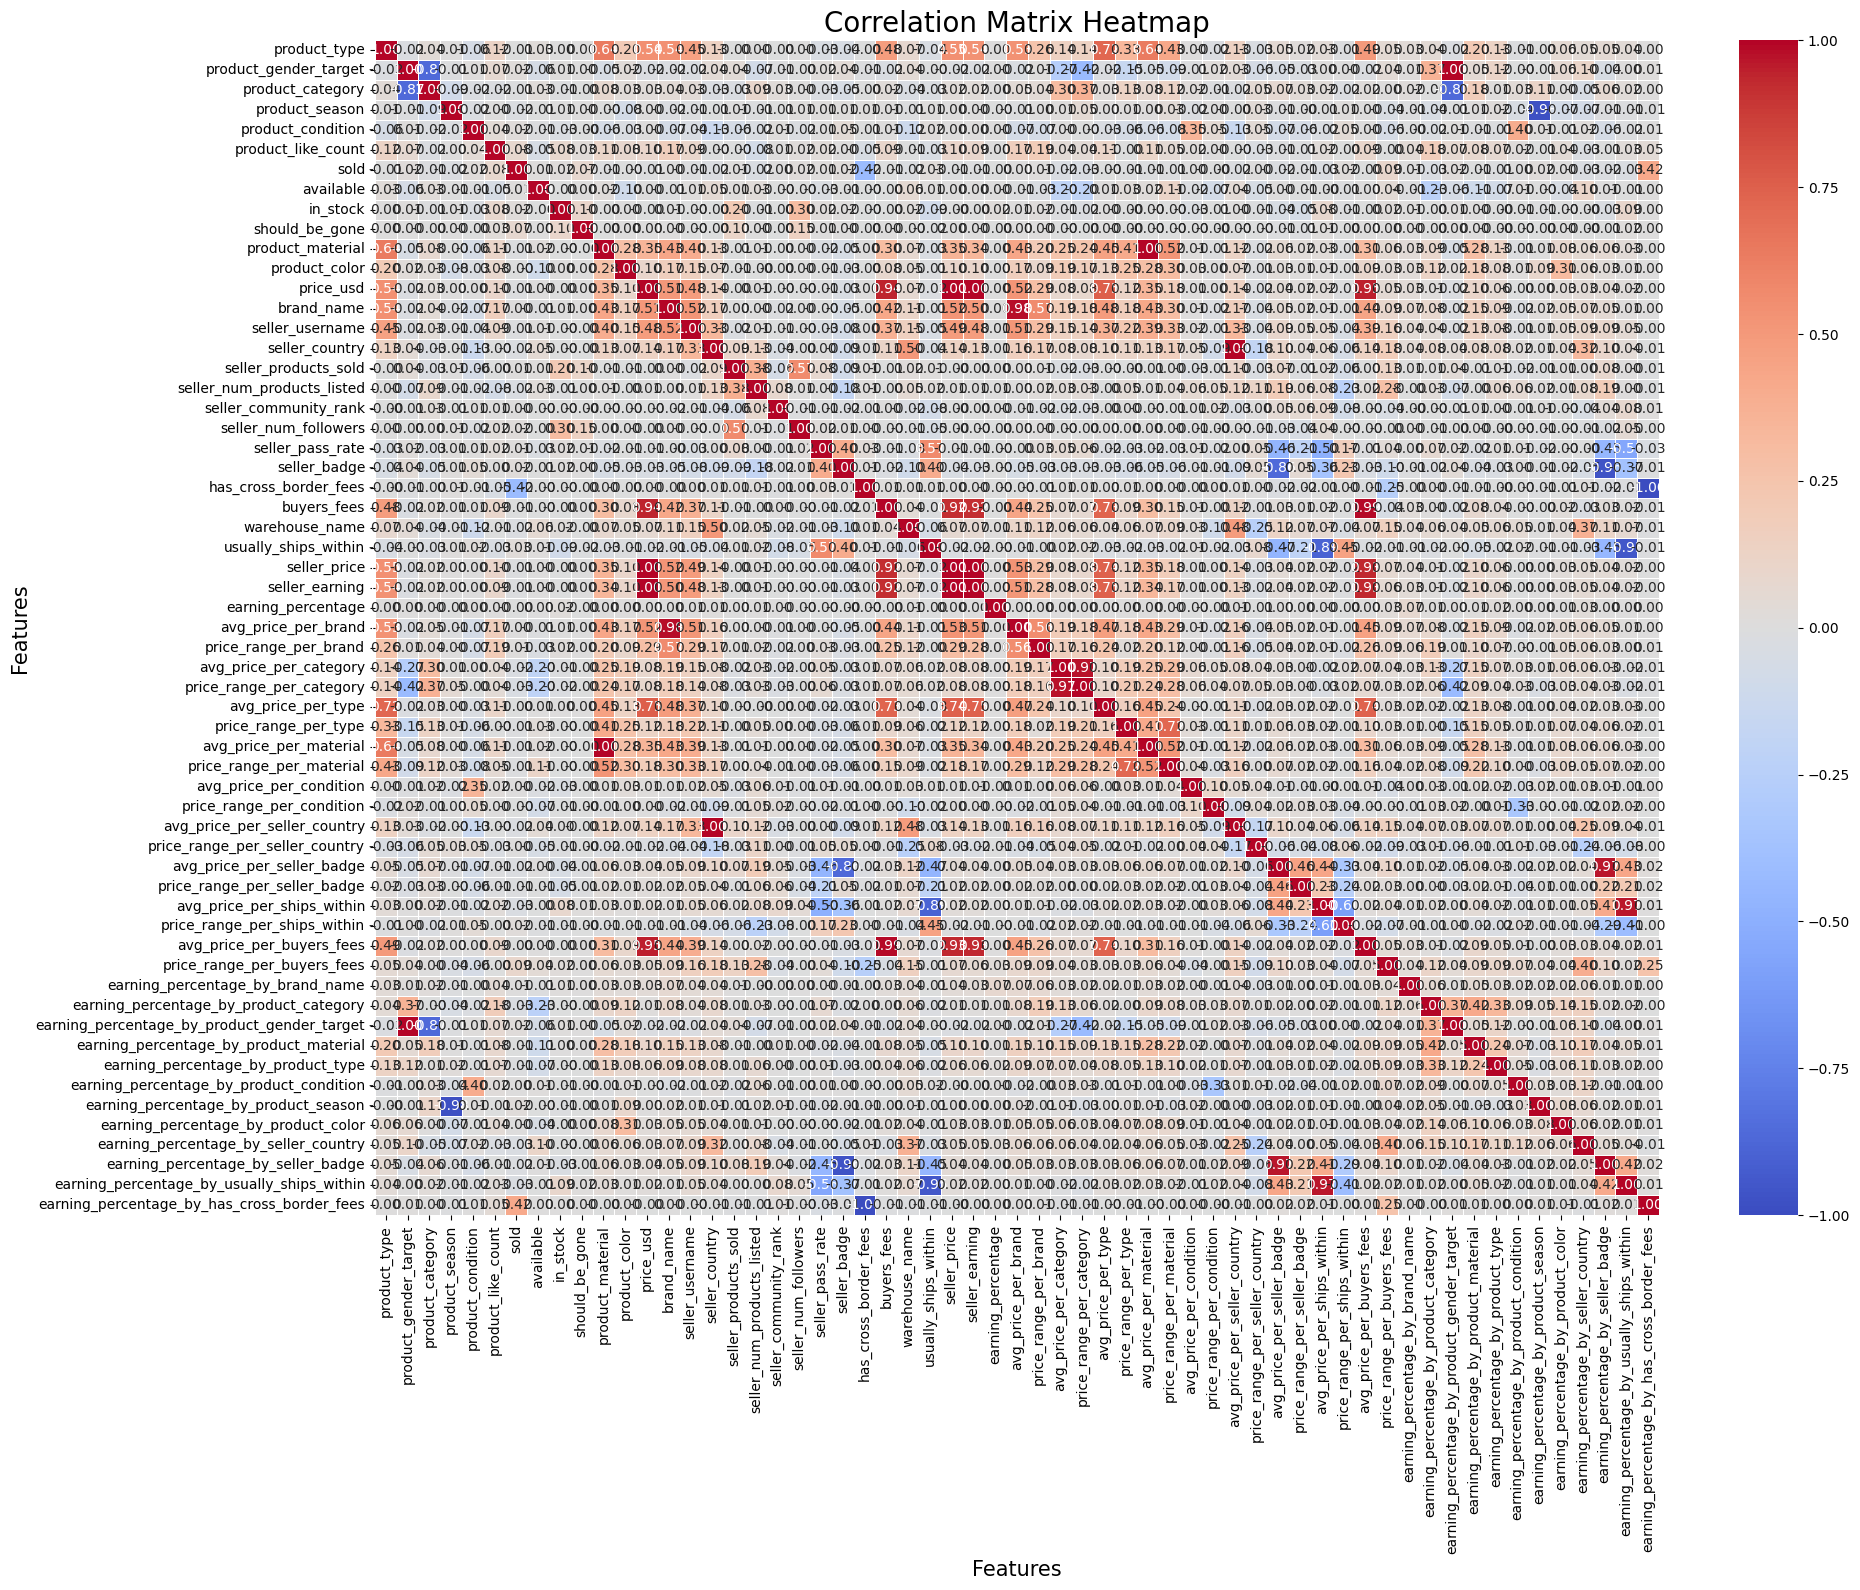

In [12]:

# Calculate the correlation matrix
corr_matrix = trial_feature_selection.corr()

# Plot the heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, vmin=-1, vmax=1)
# Rotate x and y axis labels for better readability
plt.xticks(rotation=90)
plt.yticks(rotation=0)

# Add titles and labels
plt.title('Correlation Matrix Heatmap', size=20)
plt.xlabel('Features', size=15)
plt.ylabel('Features', size=15)

# Show the plot
plt.tight_layout()
plt.show()

### Calculating VIF for handling outliers and for feature selection

In [13]:

# Calculate VIF
def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data["feature"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_data

To_predict = trial_feature_selection.drop('seller_price', axis=1)

X = add_constant(To_predict)

vif_df = calculate_vif(X) # 8 mins runtime

print(vif_df)


c:\Users\sai27\Documents\DataScience\VirtualEnvironment\.venv\Lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\sai27\Documents\DataScience\VirtualEnvironment\.venv\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


                                        feature           VIF
0                                         const  0.000000e+00
1                                  product_type  3.268753e+00
2                         product_gender_target           inf
3                              product_category  2.104296e+02
4                                product_season  2.548312e+01
5                             product_condition  1.615532e+00
6                            product_like_count  1.118421e+00
7                                          sold  1.235897e+00
8                                     available  1.257706e+00
9                                      in_stock  1.139626e+00
10                               should_be_gone  1.031820e+00
11                             product_material  1.107913e+04
12                                product_color  1.288875e+00
13                                    price_usd  8.995362e+02
14                                   brand_name  2.421603e+01
15      

### Visualizing columns with large VIFs and Remaining in seperate dataframes and heatmaps

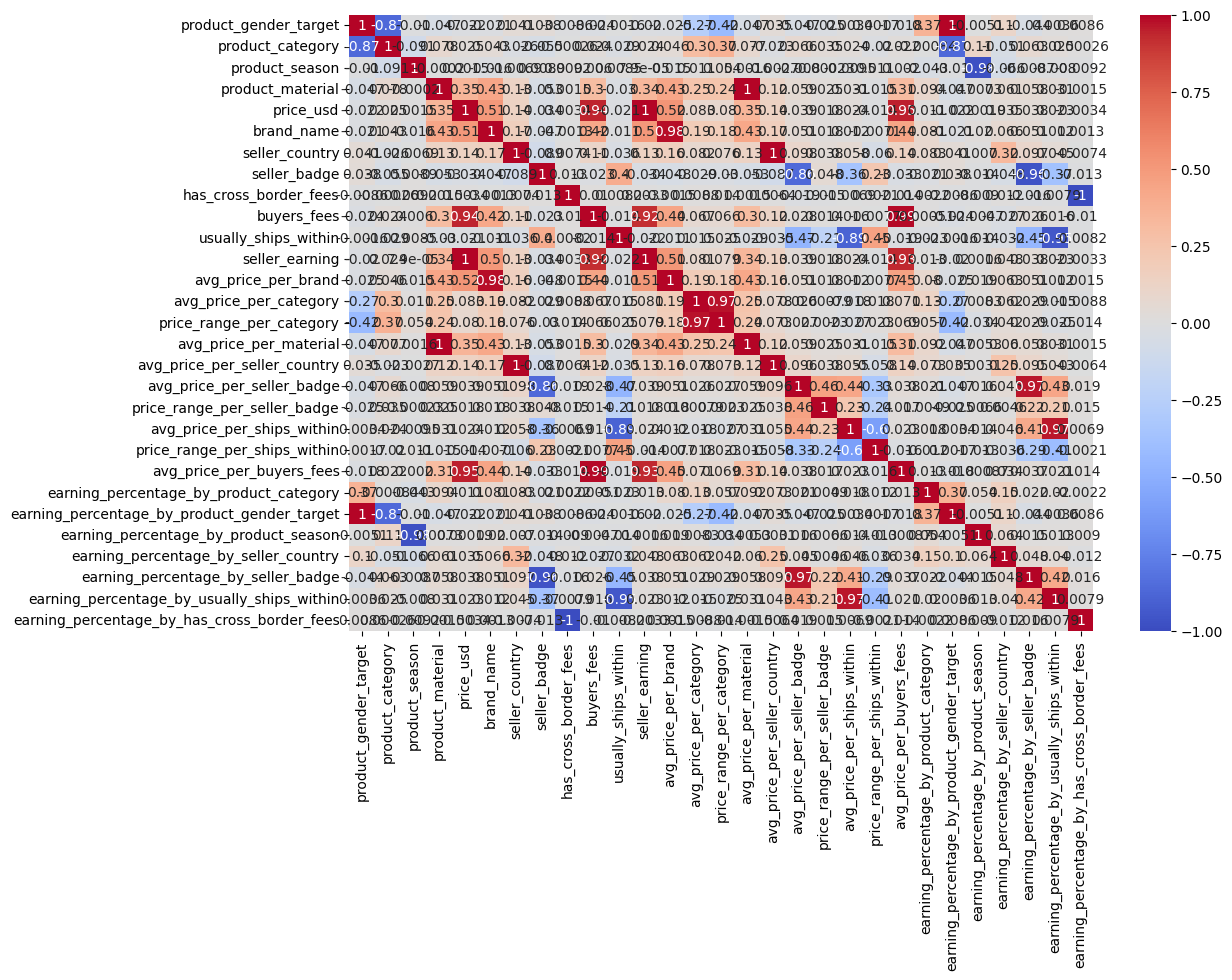

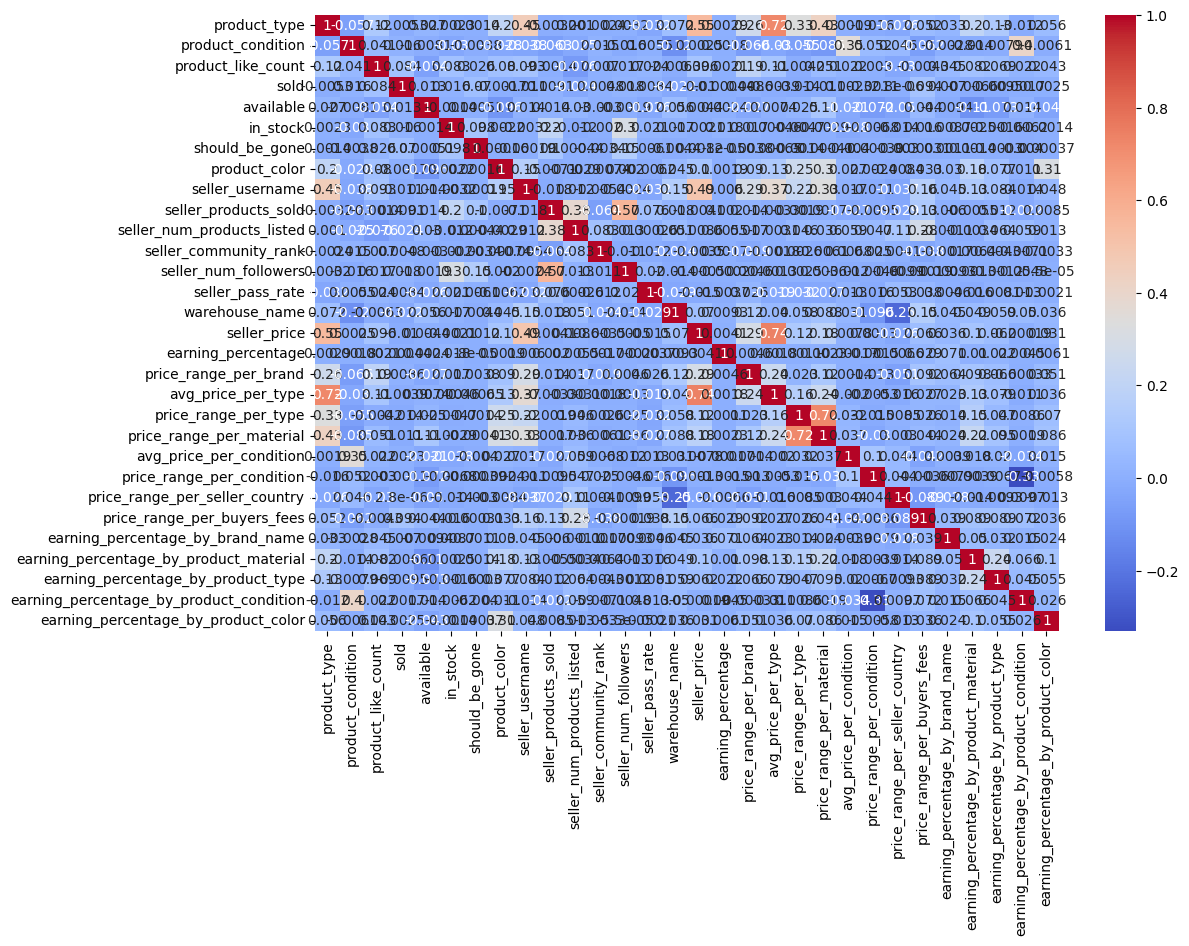

In [14]:
# Seperately viewing columns with large VIF
cols_with_large_vif = vif_df[vif_df.VIF > 4].feature

# Step 5: Create a DataFrame with only the filtered columns
filtered_large_vif_df = trial_feature_selection[cols_with_large_vif]

# Step 6: Plot the heatmap for the filtered columns
plt.figure(figsize=(12, 8))
sns.heatmap(filtered_large_vif_df.corr(), annot=True, cmap='coolwarm')
plt.show()
new_select_features_df = trial_feature_selection.drop(columns=cols_with_large_vif)

# Step 6: Plot the heatmap for the new DataFrame
plt.figure(figsize=(12, 8))
sns.heatmap(new_select_features_df.corr(), annot=True, cmap='coolwarm')
plt.show()


# Model Training and Testing

### Defining X and Y for futher model training

In [15]:

# Defining X & Y
X = new_select_features_df.drop('seller_price', axis=1)  # Predictor variables
y = new_select_features_df['seller_price']               # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model training and evaluation
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    return r2, mae, mse, rmse

## Training and Testing of Different Models

- ##### R2 is Evaluation Metric

### Linear Regression
#### Efficiency = 0.61

In [16]:

# Linear Regression - 3 mins runtime
lr_model = LinearRegression()
r2_LR, mae_LR, mse_LR, rmse_LR = evaluate_model(lr_model, X_train, y_train, X_test, y_test)
print(f"Linear Regression R-squared: {r2_LR}")

Linear Regression R-squared: 0.612410503869466


### LASSO Regression
#### Efficiency = 0.61

In [17]:
# Lasso Regression with expanded parameter grid - 32 mins runtime
lasso_params = {'alpha': np.logspace(-5, 5, 50), 'max_iter': [1000, 5000, 10000, 20000, 50000, 100000]}
lasso_cv = GridSearchCV(Lasso(), lasso_params, cv=3)
r2_Lasso, mae_Lasso, mse_Lasso, rmse_Lasso = evaluate_model(lasso_cv, X_train, y_train, X_test, y_test)
print(f"Lasso Regression R-squared: {r2_Lasso}")

Lasso Regression R-squared: 0.6124105648080986


### ElasticNet Regression
#### Efficiency = 0.61

In [ ]:
# ElasticNet Regression with expanded parameter grid - 300 mins runtime
elastic_params = {'alpha': np.logspace(-5, 5, 50), 'l1_ratio': np.linspace(0.1, 0.9, 9), 'max_iter': [1000, 5000, 10000, 20000, 50000, 100000]}
elastic_cv = GridSearchCV(ElasticNet() ,elastic_params, cv=3)
r2_ElasticNet, mae_ElasticNet, mse_ElasticNet, rmse_ElasticNet = evaluate_model(elastic_cv, X_train, y_train, X_test, y_test)
print(f"ElasticNet Regression R-squared: {r2_ElasticNet}")

## Model Evaluation

In [18]:
# Model evaluation
print(f"Linear Regression R2: {r2_LR}, MAE: {mae_LR}, MSE: {mse_LR}, RMSE: {rmse_LR}")
print(f"Lasso Regression R2: {r2_Lasso}, MAE: {mae_Lasso}, MSE: {mse_Lasso}, RMSE: {rmse_Lasso}")
#print(f"ElasticNet Regression R2: {r2_ElasticNet}, MAE: {mae_ElasticNet}, MSE: {mse_ElasticNet}, RMSE: {rmse_ElasticNet}")


Linear Regression R2: 0.612410503869466, MAE: 202.3630618978603, MSE: 687728.7728105045, RMSE: 829.2941413096469
Lasso Regression R2: 0.6124105648080986, MAE: 202.36033837050093, MSE: 687728.6646825719, RMSE: 829.2940761168935


## Cross - Validation

In [20]:

# Cross-validation
cv_scores_LR = cross_val_score(lr_model, X, new_select_features_df['seller_price'], cv=5, scoring='r2')
print(f"Linear Regression Cross-validated R2 scores: {cv_scores_LR}")
print(f"Mean R2 score: {cv_scores_LR.mean()}, Std: {cv_scores_LR.std()}")


Linear Regression Cross-validated R2 scores: [0.45282328 0.30900718 0.66053826 0.49156476 0.37519405]
Mean R2 score: 0.45782550470006883, Std: 0.11935717069730067


In [ ]:

cv_scores_Lasso = cross_val_score(lasso_cv, X, new_select_features_df['seller_price'], cv=5, scoring='r2')
print(f"Lasso Regression Cross-validated R2 scores: {cv_scores_Lasso}")
print(f"Mean R2 score: {cv_scores_Lasso.mean()}, Std: {cv_scores_Lasso.std()}")


In [ ]:

cv_scores_ElasticNet = cross_val_score(elastic_cv, X, new_select_features_df['seller_price'], cv=5, scoring='r2')
print(f"ElasticNet Regression Cross-validated R2 scores: {cv_scores_ElasticNet}")
print(f"Mean R2 score: {cv_scores_ElasticNet.mean()}, Std: {cv_scores_ElasticNet.std()}")